## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp023'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 5e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

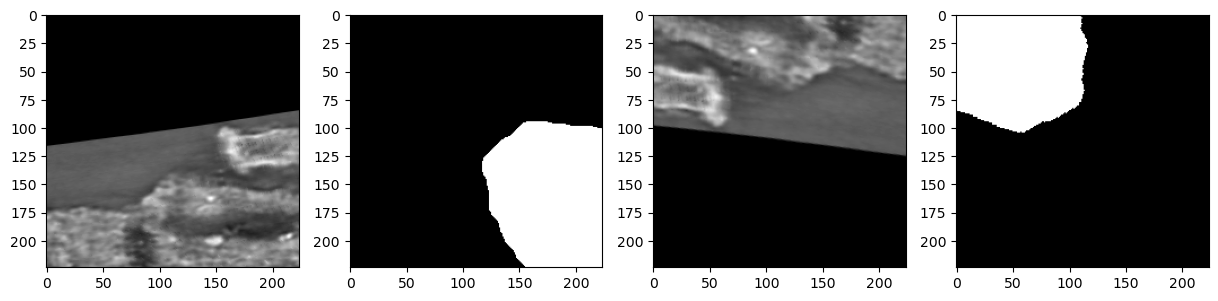

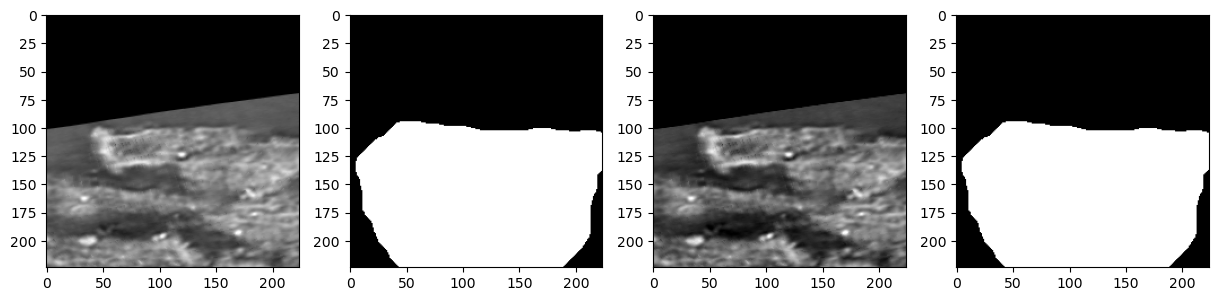

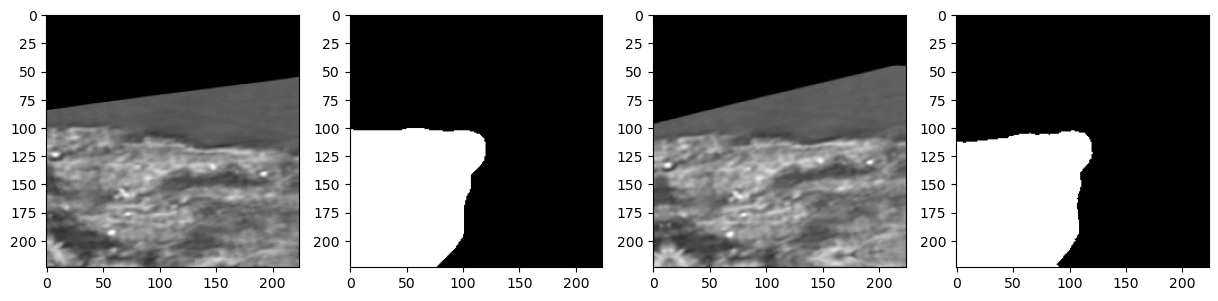

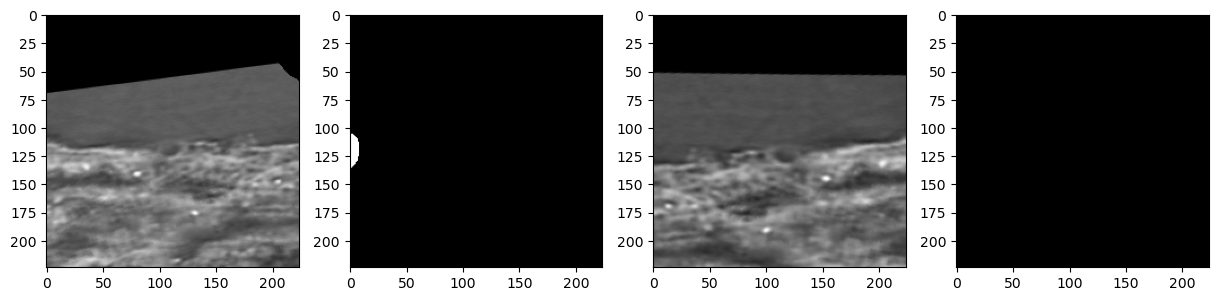

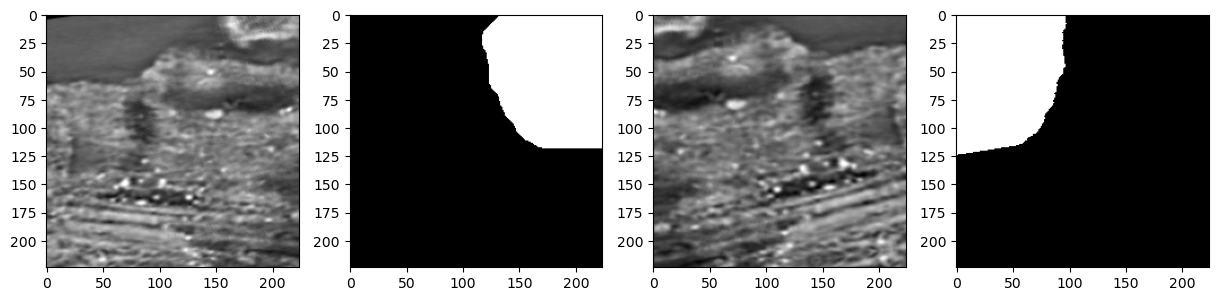

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14177796309243887
th: 0.15, fbeta: 0.20166257822337835
th: 0.2, fbeta: 0.2736014462777374
th: 0.25, fbeta: 0.35646873028658926
th: 0.3, fbeta: 0.38321897506813063
th: 0.35, fbeta: 0.3768721636367229
th: 0.4, fbeta: 0.348165236090508
th: 0.45, fbeta: 0.30440671097089617


best_th: 0.3, fbeta: 0.38321897506813063
Epoch 1 - avg_train_loss: 0.4496  avg_val_loss: 0.3450  time: 112s
Epoch 1 - avgScore: 0.3832
Epoch 1 - Save Best Score: 0.3832 Model
Epoch 1 - Save Best Loss: 0.3450 Model


th: 0.5, fbeta: 0.25332670347180025


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2965342301568652
th: 0.15, fbeta: 0.3691975495861346
th: 0.2, fbeta: 0.36223129205888394
th: 0.25, fbeta: 0.303601179262535
th: 0.3, fbeta: 0.23848157376953985
th: 0.35, fbeta: 0.1789880437669112
th: 0.4, fbeta: 0.12533408679303065
th: 0.45, fbeta: 0.08312502750281908


best_th: 0.15, fbeta: 0.3691975495861346
Epoch 2 - avg_train_loss: 0.2614  avg_val_loss: 0.3265  time: 114s
Epoch 2 - avgScore: 0.3692


th: 0.5, fbeta: 0.05273218642934113


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.31532416109682015
th: 0.15, fbeta: 0.3361513095215725
th: 0.2, fbeta: 0.28782880681721196
th: 0.25, fbeta: 0.2317821595390686
th: 0.3, fbeta: 0.18097081263825762
th: 0.35, fbeta: 0.13354392932664555
th: 0.4, fbeta: 0.09403449272520932
th: 0.45, fbeta: 0.0631976792837568


best_th: 0.15, fbeta: 0.3361513095215725
Epoch 3 - avg_train_loss: 0.2383  avg_val_loss: 0.3222  time: 113s
Epoch 3 - avgScore: 0.3362


th: 0.5, fbeta: 0.029058189913513926


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.278804316033916
th: 0.15, fbeta: 0.1850630596874865
th: 0.2, fbeta: 0.11477291674326447
th: 0.25, fbeta: 0.0648899927790882
th: 0.3, fbeta: 0.03216890410512156
th: 0.35, fbeta: 0.014806517293855624
th: 0.4, fbeta: 0.00773011317908218
th: 0.45, fbeta: 0.0029545893328729654


best_th: 0.1, fbeta: 0.278804316033916
Epoch 4 - avg_train_loss: 0.2156  avg_val_loss: 0.3783  time: 113s
Epoch 4 - avgScore: 0.2788


th: 0.5, fbeta: 0.00048481422883879657


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37073423541550216
th: 0.15, fbeta: 0.3283080384273553
th: 0.2, fbeta: 0.23172280125769493
th: 0.25, fbeta: 0.14848887176948247
th: 0.3, fbeta: 0.09192341355814461
th: 0.35, fbeta: 0.059995900072291136
th: 0.4, fbeta: 0.03965580832544522
th: 0.45, fbeta: 0.026107405595100414


best_th: 0.1, fbeta: 0.37073423541550216
Epoch 5 - avg_train_loss: 0.2054  avg_val_loss: 0.3693  time: 113s
Epoch 5 - avgScore: 0.3707


th: 0.5, fbeta: 0.016607130336519966


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.370433448772021
th: 0.15, fbeta: 0.3668533993843174
th: 0.2, fbeta: 0.3544019712978336
th: 0.25, fbeta: 0.33839910340757773
th: 0.3, fbeta: 0.31785643669094443
th: 0.35, fbeta: 0.2911723242952166
th: 0.4, fbeta: 0.2603942127774885
th: 0.45, fbeta: 0.22721799243438381


best_th: 0.1, fbeta: 0.370433448772021
Epoch 6 - avg_train_loss: 0.2002  avg_val_loss: 0.4171  time: 113s
Epoch 6 - avgScore: 0.3704


th: 0.5, fbeta: 0.18953407390146046


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34838986801243527
th: 0.15, fbeta: 0.3787554238007999
th: 0.2, fbeta: 0.3832913376905164
th: 0.25, fbeta: 0.3720240704774395
th: 0.3, fbeta: 0.35454730217558533
th: 0.35, fbeta: 0.33462960463009195
th: 0.4, fbeta: 0.30848381301705474
th: 0.45, fbeta: 0.27929393305957906


best_th: 0.2, fbeta: 0.3832913376905164
Epoch 7 - avg_train_loss: 0.1965  avg_val_loss: 0.3639  time: 113s
Epoch 7 - avgScore: 0.3833
Epoch 7 - Save Best Score: 0.3833 Model
Epoch 7 - Save Best Loss: 0.3639 Model


th: 0.5, fbeta: 0.24766488376095555


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.397094012916251
th: 0.15, fbeta: 0.397496921884944
th: 0.2, fbeta: 0.3900887291155882
th: 0.25, fbeta: 0.37603510607813573
th: 0.3, fbeta: 0.3546404653591586
th: 0.35, fbeta: 0.3307457857499706
th: 0.4, fbeta: 0.3018964466058705
th: 0.45, fbeta: 0.26412842938382597


best_th: 0.15, fbeta: 0.397496921884944
Epoch 8 - avg_train_loss: 0.1919  avg_val_loss: 0.4116  time: 114s
Epoch 8 - avgScore: 0.3975
Epoch 8 - Save Best Score: 0.3975 Model
Epoch 8 - Save Best Loss: 0.4116 Model


th: 0.5, fbeta: 0.22006265881274084


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36355591516180263
th: 0.15, fbeta: 0.3918938795186574
th: 0.2, fbeta: 0.39837360321484244
th: 0.25, fbeta: 0.39029305132906544
th: 0.3, fbeta: 0.372643053066265
th: 0.35, fbeta: 0.34786255471126193
th: 0.4, fbeta: 0.3148836100082911
th: 0.45, fbeta: 0.275661293541144


best_th: 0.2, fbeta: 0.39837360321484244
Epoch 9 - avg_train_loss: 0.1874  avg_val_loss: 0.3645  time: 114s
Epoch 9 - avgScore: 0.3984
Epoch 9 - Save Best Score: 0.3984 Model
Epoch 9 - Save Best Loss: 0.3645 Model


th: 0.5, fbeta: 0.23145642509637038


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36847770608409874
th: 0.15, fbeta: 0.3525739408158483
th: 0.2, fbeta: 0.32167187529423547
th: 0.25, fbeta: 0.28854692190649706
th: 0.3, fbeta: 0.25724458945071954
th: 0.35, fbeta: 0.22734720289482194
th: 0.4, fbeta: 0.19889133766023873
th: 0.45, fbeta: 0.1709006450390369


best_th: 0.1, fbeta: 0.36847770608409874
Epoch 10 - avg_train_loss: 0.1842  avg_val_loss: 0.4018  time: 114s
Epoch 10 - avgScore: 0.3685


th: 0.5, fbeta: 0.14643467276667158


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.418122554831236
th: 0.15, fbeta: 0.4058288570427599
th: 0.2, fbeta: 0.37275668468213513
th: 0.25, fbeta: 0.3229639777151534
th: 0.3, fbeta: 0.274295487859335
th: 0.35, fbeta: 0.22526238006241103
th: 0.4, fbeta: 0.17449202079838805
th: 0.45, fbeta: 0.13055383338771212


best_th: 0.1, fbeta: 0.418122554831236
Epoch 11 - avg_train_loss: 0.1793  avg_val_loss: 0.4294  time: 114s
Epoch 11 - avgScore: 0.4181
Epoch 11 - Save Best Score: 0.4181 Model
Epoch 11 - Save Best Loss: 0.4294 Model


th: 0.5, fbeta: 0.09590508811545435


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41561791791995806
th: 0.15, fbeta: 0.414381492353025
th: 0.2, fbeta: 0.4004706075565445
th: 0.25, fbeta: 0.3771972179050382
th: 0.3, fbeta: 0.350697980403294
th: 0.35, fbeta: 0.31951592342626856
th: 0.4, fbeta: 0.28456109285930303
th: 0.45, fbeta: 0.2500921413940985


best_th: 0.1, fbeta: 0.41561791791995806
Epoch 12 - avg_train_loss: 0.1740  avg_val_loss: 0.4709  time: 114s
Epoch 12 - avgScore: 0.4156


th: 0.5, fbeta: 0.21817817974638898


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3405841022363127
th: 0.15, fbeta: 0.37138529252410835
th: 0.2, fbeta: 0.39380102089898705
th: 0.25, fbeta: 0.41149380509547534
th: 0.3, fbeta: 0.42373660215225795
th: 0.35, fbeta: 0.43128478422407884
th: 0.4, fbeta: 0.432739109876897
th: 0.45, fbeta: 0.42736692688567396


best_th: 0.4, fbeta: 0.432739109876897
Epoch 13 - avg_train_loss: 0.1700  avg_val_loss: 0.3714  time: 114s
Epoch 13 - avgScore: 0.4327
Epoch 13 - Save Best Score: 0.4327 Model
Epoch 13 - Save Best Loss: 0.3714 Model


th: 0.5, fbeta: 0.41249741881272023


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39464286994908127
th: 0.15, fbeta: 0.39897142563038146
th: 0.2, fbeta: 0.38487137852088316
th: 0.25, fbeta: 0.35629627442079426
th: 0.3, fbeta: 0.3190628454144395
th: 0.35, fbeta: 0.27829757264503086
th: 0.4, fbeta: 0.23890894033876814
th: 0.45, fbeta: 0.20230807103620801


best_th: 0.15, fbeta: 0.39897142563038146
Epoch 14 - avg_train_loss: 0.1664  avg_val_loss: 0.4435  time: 114s
Epoch 14 - avgScore: 0.3990


th: 0.5, fbeta: 0.1698424978017334


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41079267027423777
th: 0.15, fbeta: 0.414714953886193
th: 0.2, fbeta: 0.4073137891356449
th: 0.25, fbeta: 0.39114959110211095
th: 0.3, fbeta: 0.370648010697718
th: 0.35, fbeta: 0.34820623673364076
th: 0.4, fbeta: 0.3208044172331924
th: 0.45, fbeta: 0.29054093619944177


best_th: 0.15, fbeta: 0.414714953886193
Epoch 15 - avg_train_loss: 0.1656  avg_val_loss: 0.4661  time: 114s
Epoch 15 - avgScore: 0.4147


th: 0.5, fbeta: 0.25817970135444923


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3822482436994783
th: 0.15, fbeta: 0.39000539095073605
th: 0.2, fbeta: 0.38689818864903713
th: 0.25, fbeta: 0.3796660574097855
th: 0.3, fbeta: 0.3681310025649838
th: 0.35, fbeta: 0.352244017397486
th: 0.4, fbeta: 0.33146185025673236
th: 0.45, fbeta: 0.31042131803161205


best_th: 0.15, fbeta: 0.39000539095073605
Epoch 16 - avg_train_loss: 0.1564  avg_val_loss: 0.5376  time: 114s
Epoch 16 - avgScore: 0.3900


th: 0.5, fbeta: 0.2858567141273723


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38418368766542255
th: 0.15, fbeta: 0.41250477669203356
th: 0.2, fbeta: 0.4286403647502032
th: 0.25, fbeta: 0.43454115601789994
th: 0.3, fbeta: 0.4309279736424802
th: 0.35, fbeta: 0.41882222895343213
th: 0.4, fbeta: 0.3988491788338964
th: 0.45, fbeta: 0.3734985316981951


best_th: 0.25, fbeta: 0.43454115601789994
Epoch 17 - avg_train_loss: 0.1530  avg_val_loss: 0.3990  time: 114s
Epoch 17 - avgScore: 0.4345
Epoch 17 - Save Best Score: 0.4345 Model
Epoch 17 - Save Best Loss: 0.3990 Model


th: 0.5, fbeta: 0.34527508238979804


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3902253333718728
th: 0.15, fbeta: 0.4029914571684388
th: 0.2, fbeta: 0.40220510404975257
th: 0.25, fbeta: 0.39160760740343536
th: 0.3, fbeta: 0.37663810940736936
th: 0.35, fbeta: 0.3517740434740175
th: 0.4, fbeta: 0.326471530820792
th: 0.45, fbeta: 0.30044173772559507


best_th: 0.15, fbeta: 0.4029914571684388
Epoch 18 - avg_train_loss: 0.1470  avg_val_loss: 0.4367  time: 115s
Epoch 18 - avgScore: 0.4030


th: 0.5, fbeta: 0.27528403428987025


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4074898894835985
th: 0.15, fbeta: 0.40785185487699427
th: 0.2, fbeta: 0.39176275025564194
th: 0.25, fbeta: 0.3644167138256874
th: 0.3, fbeta: 0.33261200079530284
th: 0.35, fbeta: 0.2942730507708427
th: 0.4, fbeta: 0.25031616168263116
th: 0.45, fbeta: 0.20857211085537156


best_th: 0.15, fbeta: 0.40785185487699427
Epoch 19 - avg_train_loss: 0.1396  avg_val_loss: 0.4507  time: 113s
Epoch 19 - avgScore: 0.4079


th: 0.5, fbeta: 0.16910723164548433


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36226632185093977
th: 0.15, fbeta: 0.3226099599015884
th: 0.2, fbeta: 0.2809382321101745
th: 0.25, fbeta: 0.24346365792576466
th: 0.3, fbeta: 0.2090059802238327
th: 0.35, fbeta: 0.1757289443868586
th: 0.4, fbeta: 0.14442758117443596
th: 0.45, fbeta: 0.11724912500014202


best_th: 0.1, fbeta: 0.36226632185093977
Epoch 20 - avg_train_loss: 0.1384  avg_val_loss: 0.5414  time: 114s
Epoch 20 - avgScore: 0.3623


th: 0.5, fbeta: 0.0949766021500396


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3917478551274539
th: 0.15, fbeta: 0.3742460705591996
th: 0.2, fbeta: 0.34696687024922657
th: 0.25, fbeta: 0.3157319836127447
th: 0.3, fbeta: 0.28595213781057166
th: 0.35, fbeta: 0.25747304965422346
th: 0.4, fbeta: 0.22644856380657008
th: 0.45, fbeta: 0.19275678164296814


best_th: 0.1, fbeta: 0.3917478551274539
Epoch 21 - avg_train_loss: 0.1329  avg_val_loss: 0.5926  time: 113s
Epoch 21 - avgScore: 0.3917


th: 0.5, fbeta: 0.1646585725205092


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4230540730768547
th: 0.15, fbeta: 0.42524421526207806
th: 0.2, fbeta: 0.4160803905926072
th: 0.25, fbeta: 0.40235367145286777
th: 0.3, fbeta: 0.385164001957483
th: 0.35, fbeta: 0.36397420469325337
th: 0.4, fbeta: 0.340085534050596
th: 0.45, fbeta: 0.31389594032566376


best_th: 0.15, fbeta: 0.42524421526207806
Epoch 22 - avg_train_loss: 0.1275  avg_val_loss: 0.5441  time: 113s
Epoch 22 - avgScore: 0.4252


th: 0.5, fbeta: 0.2858963038962899


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39943816707953206
th: 0.15, fbeta: 0.39312849896634067
th: 0.2, fbeta: 0.37891312325021614
th: 0.25, fbeta: 0.36081014715534826
th: 0.3, fbeta: 0.33839355822294254
th: 0.35, fbeta: 0.3160766174859408
th: 0.4, fbeta: 0.295000591522007
th: 0.45, fbeta: 0.2728535789527852


best_th: 0.1, fbeta: 0.39943816707953206
Epoch 23 - avg_train_loss: 0.1254  avg_val_loss: 0.5577  time: 113s
Epoch 23 - avgScore: 0.3994


th: 0.5, fbeta: 0.2497449635099397


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39892925778105326
th: 0.15, fbeta: 0.38577416907894935
th: 0.2, fbeta: 0.37145407997785973
th: 0.25, fbeta: 0.35406964573461847
th: 0.3, fbeta: 0.3339924993486696
th: 0.35, fbeta: 0.309842261913642
th: 0.4, fbeta: 0.28446197709262494
th: 0.45, fbeta: 0.25809777908708387


best_th: 0.1, fbeta: 0.39892925778105326
Epoch 24 - avg_train_loss: 0.1187  avg_val_loss: 0.5409  time: 114s
Epoch 24 - avgScore: 0.3989


th: 0.5, fbeta: 0.2330666055799745


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40575659910391926
th: 0.15, fbeta: 0.39526828676726045
th: 0.2, fbeta: 0.37857043275832036
th: 0.25, fbeta: 0.3580186370417428
th: 0.3, fbeta: 0.33494647564459606
th: 0.35, fbeta: 0.31272085883421014
th: 0.4, fbeta: 0.29056953184581985
th: 0.45, fbeta: 0.2661676516420031


best_th: 0.1, fbeta: 0.40575659910391926
Epoch 25 - avg_train_loss: 0.1158  avg_val_loss: 0.6175  time: 113s
Epoch 25 - avgScore: 0.4058


th: 0.5, fbeta: 0.24050699801155564


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3996394515120397
th: 0.15, fbeta: 0.4005212366472259
th: 0.2, fbeta: 0.3926000818017067
th: 0.25, fbeta: 0.37941559036994765
th: 0.3, fbeta: 0.3613330737679755
th: 0.35, fbeta: 0.3387206414897816
th: 0.4, fbeta: 0.31321928151746364
th: 0.45, fbeta: 0.2866271309264966


best_th: 0.15, fbeta: 0.4005212366472259
Epoch 26 - avg_train_loss: 0.1158  avg_val_loss: 0.5349  time: 114s
Epoch 26 - avgScore: 0.4005


th: 0.5, fbeta: 0.25614044070316055


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.393193469608684
th: 0.15, fbeta: 0.37477092741302154
th: 0.2, fbeta: 0.35536973273374994
th: 0.25, fbeta: 0.3344190848965952
th: 0.3, fbeta: 0.3109465137547266
th: 0.35, fbeta: 0.28607062107780684
th: 0.4, fbeta: 0.26137988937772383
th: 0.45, fbeta: 0.23592971618446068


best_th: 0.1, fbeta: 0.393193469608684
Epoch 27 - avg_train_loss: 0.1109  avg_val_loss: 0.5729  time: 114s
Epoch 27 - avgScore: 0.3932


th: 0.5, fbeta: 0.2108689444351032


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39738188459153145
th: 0.15, fbeta: 0.386749283716619
th: 0.2, fbeta: 0.3667865000708461
th: 0.25, fbeta: 0.3445943155357172
th: 0.3, fbeta: 0.3239869721852021
th: 0.35, fbeta: 0.30227102997863026
th: 0.4, fbeta: 0.2787925372909176
th: 0.45, fbeta: 0.2545438055384082


best_th: 0.1, fbeta: 0.39738188459153145
Epoch 28 - avg_train_loss: 0.1078  avg_val_loss: 0.6169  time: 113s
Epoch 28 - avgScore: 0.3974


th: 0.5, fbeta: 0.2296686610168546


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40172554916385067
th: 0.15, fbeta: 0.3918144423766214
th: 0.2, fbeta: 0.3767580698048661
th: 0.25, fbeta: 0.3578103898656179
th: 0.3, fbeta: 0.3357650702147893
th: 0.35, fbeta: 0.31520653813530763
th: 0.4, fbeta: 0.29367544269490786
th: 0.45, fbeta: 0.27002720174802286


best_th: 0.1, fbeta: 0.40172554916385067
Epoch 29 - avg_train_loss: 0.1043  avg_val_loss: 0.5969  time: 115s
Epoch 29 - avgScore: 0.4017


th: 0.5, fbeta: 0.24595358259785535


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39796814348143994
th: 0.15, fbeta: 0.37890298584858634
th: 0.2, fbeta: 0.35759069515297826
th: 0.25, fbeta: 0.3351167554370728
th: 0.3, fbeta: 0.3114352778752299
th: 0.35, fbeta: 0.28691046446357205
th: 0.4, fbeta: 0.263409674604765
th: 0.45, fbeta: 0.23829715317867553


best_th: 0.1, fbeta: 0.39796814348143994
Epoch 30 - avg_train_loss: 0.1051  avg_val_loss: 0.6152  time: 113s
Epoch 30 - avgScore: 0.3980


th: 0.5, fbeta: 0.21155452183974274


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.38418368766542255
th: 0.15, fbeta: 0.41250477669203356
th: 0.2, fbeta: 0.4286403647502032
th: 0.25, fbeta: 0.43454115601789994
th: 0.3, fbeta: 0.4309279736424802
th: 0.35, fbeta: 0.41882222895343213
th: 0.4, fbeta: 0.3988491788338964
th: 0.45, fbeta: 0.3734985316981951


best_th: 0.25, fbeta: 0.43454115601789994


th: 0.5, fbeta: 0.34527508238979804


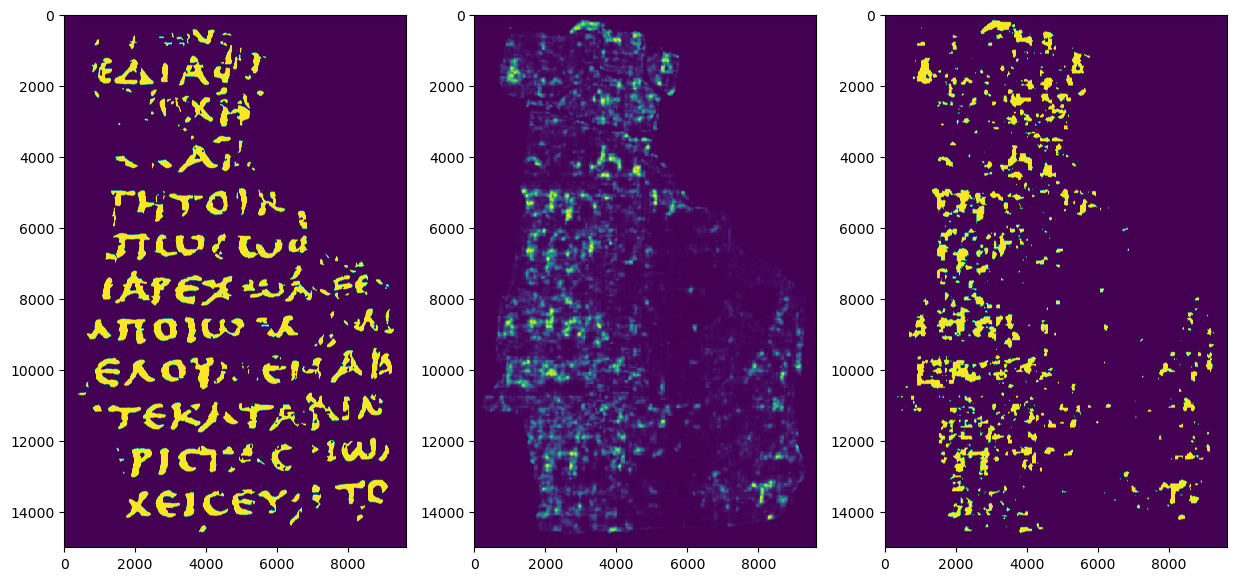

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.10812629e+08, 1.20483810e+07, 5.94147700e+06, 3.69161800e+06,
        2.57373200e+06, 1.95275000e+06, 1.47756100e+06, 1.15952600e+06,
        9.13666000e+05, 7.20141000e+05, 5.94504000e+05, 4.98737000e+05,
        4.23104000e+05, 3.64446000e+05, 3.27509000e+05, 2.97529000e+05,
        2.57975000e+05, 2.38289000e+05, 1.71206000e+05, 9.22760000e+04]),
 array([2.49732535e-11, 4.99000080e-02, 9.98000160e-02, 1.49700024e-01,
        1.99600032e-01, 2.49500040e-01, 2.99400048e-01, 3.49300056e-01,
        3.99200064e-01, 4.49100072e-01, 4.99000080e-01, 5.48900088e-01,
        5.98800096e-01, 6.48700104e-01, 6.98600112e-01, 7.48500120e-01,
        7.98400128e-01, 8.48300136e-01, 8.98200144e-01, 9.48100152e-01,
        9.98000160e-01]),
 <BarContainer object of 20 artists>)

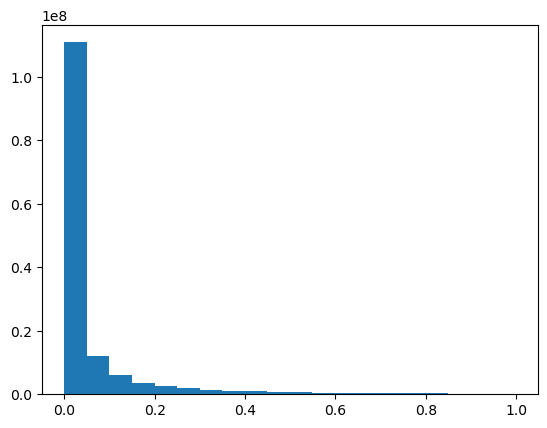

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000